<a href="https://colab.research.google.com/github/Assis-Mohanty/Makemore/blob/main/MakeMore2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [4]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
block_size=3
X,Y=[],[]
for w in words [:5]:
  print(w)
  content=[0]*block_size
  for ch in w + '.':
    ix=stoi[ch]
    X.append(content)
    Y.append(ix)
    print(''.join(itos[i] for i in content),'--->',itos[ix])
    content=content[1:]+[ix]
X=torch.tensor(X)
Y=torch.tensor(Y)



emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [8]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [9]:
C=torch.randn((27,2))

In [10]:
emb=C[X]
emb.shape

torch.Size([32, 3, 2])

In [11]:
W1=torch.randn((6,100))
b1=torch.randn(100)

In [17]:
torch.cat([emb[:,0,:],emb[:,1,:],emb[:,2,:]],1).shape

torch.Size([32, 6])

In [18]:
a=torch.ones([3,2,5])
a

tensor([[[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.]]])

In [19]:
a.unbind(2)

(tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor([[1., 1.],
         [1., 1.],
         [1., 1.]]))

In [22]:
torch.cat(torch.unbind(emb,1),1).shape

torch.Size([32, 6])

In [23]:
emb.shape

torch.Size([32, 3, 2])

In [24]:
emb.view(32,6).shape

torch.Size([32, 6])

In [25]:
h=torch.tanh(emb.view(-1,6) @ W1 + b1)

In [27]:
h.shape

torch.Size([32, 100])

In [30]:
W2 =torch.randn(100,27)
b2=torch.randn(27)

In [37]:
output = h @ W2 + b2
output.shape

torch.Size([32, 27])

In [33]:
expt=output.exp()
expt.shape

torch.Size([32, 27])

In [35]:
prob=expt/expt.sum(1,keepdim=True)

In [36]:
prob.shape

torch.Size([32, 27])

In [39]:
loss = -prob[torch.arange(32),Y].log().mean()
loss

tensor(16.1602)

In [40]:
# train validation and split


In [50]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [51]:
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,10),generator=g)
W1=torch.randn(30,200,generator=g)
b1=torch.randn(200,generator=g)
W2=torch.randn(200,27,generator=g)
b2=torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]

In [52]:
sum(p.nelement() for p in parameters)

11897

In [53]:
for p in parameters:
  p.requires_grad=True

In [54]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre

In [55]:
lri=[]
lossi=[]
stepi=[]

In [65]:
for i in range(100000):

  #minibatch
  ix=torch.randint(0,Xtr.shape[0],(32,))

  #forwardpass

  emb=C[Xtr[ix]]
  h=torch.tanh(emb.view(-1,30)@ W1+b1)
  act=h @ W2 + b2
  loss=F.cross_entropy(act,Ytr[ix])
  # print(loss)

  #backward pass
  for p in parameters:
    p.grad=None
  loss.backward()

  #update
  lr=0.1 if i <100000 else 0.01
  for p in parameters:
    p.data+=-lr*p.grad
  stepi.append(i)
  lossi.append(loss.log10().item())
print(loss)

tensor(2.1003, grad_fn=<NllLossBackward0>)


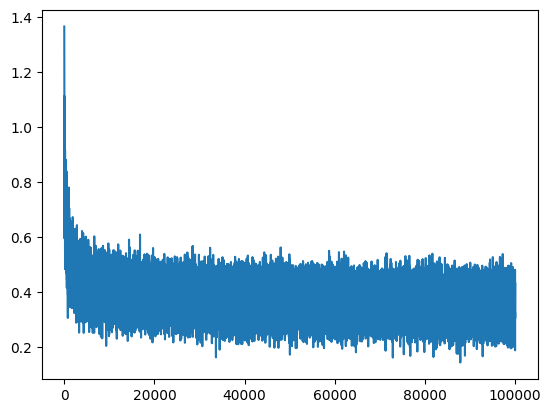

In [66]:
plt.plot(stepi, lossi)

In [67]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.3628, grad_fn=<NllLossBackward0>)

In [68]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.3980, grad_fn=<NllLossBackward0>)

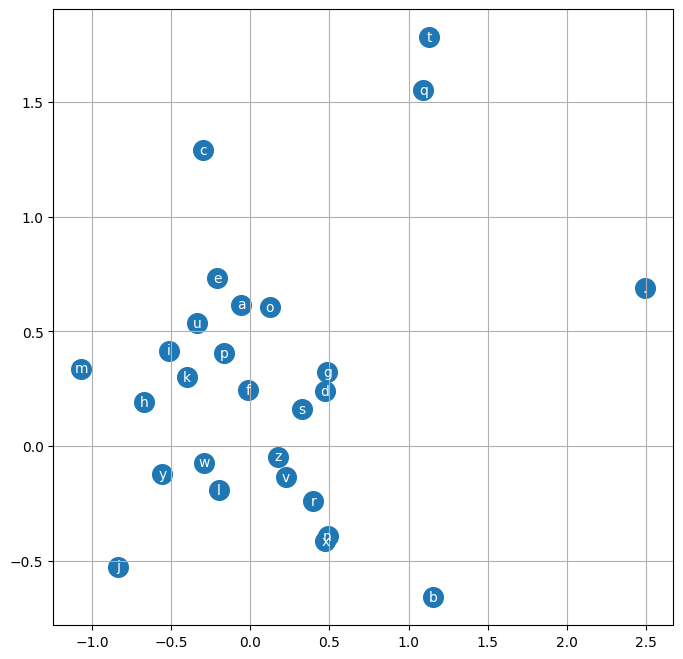

In [69]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [70]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

eria.
kayah.
keer.
nduryah.
rehura.
ekdraro.
adeeronelie.
shyarearadelsenna.
araelynnorokesti.
sadhvrieharies.
kazireelleennon.
caylee.
neder.
yadalyeha.
kayjaysen.
dazhia.
salyansun.
zakarverren.
cre.
kaveaoanna.
